# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player Matchup Diff Data


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/7.0.3-atp_diff-ohe-history_diff.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/7.0.3-atp_diff-ohe-history_diff.ipynb) where we aggregated match data for each player for the most recent 10 matches leading up to each match. We will use this data compared to data with only 5 matchups to see if this makes a difference in our model accuracy

We will be using the diff data for our matchups since this preformed the best when trying different data from matchup data

Data that we obtained for each player:

* p1_matchup_wins_diff = p1_matchup_wins - p2_matchup_wins
* p1_matchup_games_diff = p1_matchup_games (won) - p2_matchup_games (won)
* p1_matchup_sets_diff = p1_matchup_sets (won) - p2_matchup_sets (won)

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.925793382849426

ROC/AUC Score: 0.9257583124191925
              precision    recall  f1-score   support

        Loss       0.92      0.93      0.93      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results

Simiarly to historical data from 10 previous matches, using matchup data from 10 previous matches actually did worse with Decision Tree than just using 5 matches

```
Model Score: 0.9234976367319379

ROC/AUC Score: 0.9234694730811022
              precision    recall  f1-score   support

        Loss       0.92      0.93      0.92      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup10_diff"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history10-matchup10.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all columns that doesn't have diff
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('diff', col)]
    data = data.drop(matchup_columns, axis=1)

    print(f'After: data.shape {data.shape}')
    
    return data
    
X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (44429, 5293)
After: data.shape (44429, 5254)
Before: data.shape (14810, 5293)
After: data.shape (14810, 5254)


In [4]:
[col for col in X_train.columns if re.search('history', col)]

[]

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6717758271438218

ROC/AUC Score: 0.6718412595512003
              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.67      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4932  2521
Win   2340  5017


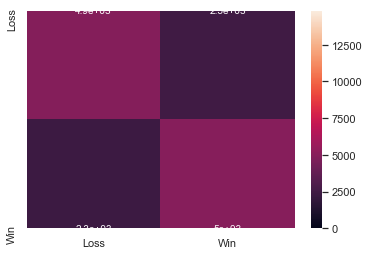

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8323430114787306

ROC/AUC Score: 0.8322497391610233
              precision    recall  f1-score   support

        Loss       0.82      0.85      0.84      7453
         Win       0.84      0.82      0.83      7357

    accuracy                           0.83     14810
   macro avg       0.83      0.83      0.83     14810
weighted avg       0.83      0.83      0.83     14810

      Loss   Win
Loss  6310  1143
Win   1340  6017


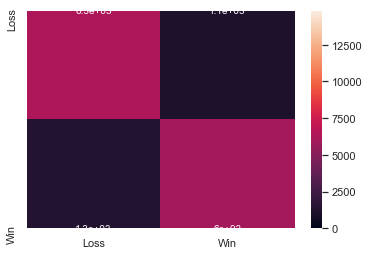

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9234976367319379

ROC/AUC Score: 0.9234694730811022
              precision    recall  f1-score   support

        Loss       0.92      0.93      0.92      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810

      Loss   Win
Loss  6915   538
Win    595  6762


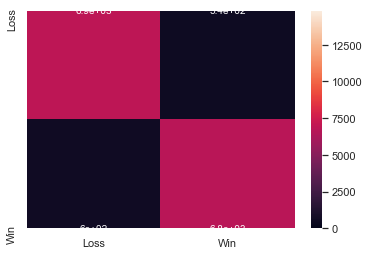

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7968939905469278

ROC/AUC Score: 0.796675358776355
              precision    recall  f1-score   support

        Loss       0.78      0.83      0.80      7453
         Win       0.82      0.76      0.79      7357

    accuracy                           0.80     14810
   macro avg       0.80      0.80      0.80     14810
weighted avg       0.80      0.80      0.80     14810

      Loss   Win
Loss  6189  1264
Win   1744  5613


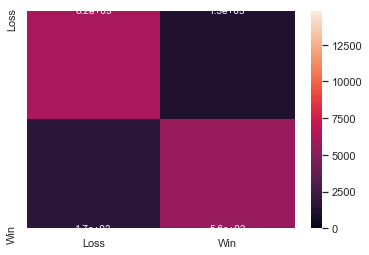

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157           14.09m
         2           1.2579           13.34m
         3           1.2102           13.17m
         4           1.1722           12.48m
         5           1.1405           11.89m
         6           1.1058           11.47m
         7           1.0785           11.30m
         8           1.0558           10.97m
         9           1.0321           10.79m
        10           1.0159           10.53m
        20           0.8899            9.82m
        30           0.8228            8.40m
        40           0.7862            7.05m
        50           0.7597            5.79m
        60           0.7419            4.56m
        70           0.7299            3.36m
        80           0.7147            2.21m
        90           0.7001            1.10m
       100           0.6898            0.00s


Model Score: 0.849763673193788

ROC/AUC Score: 0.8496282380047855
              precision    recall  f1-score   support

        Loss       0.84      0.87      0.85      7453
         Win       0.86      0.83      0.85      7357

    accuracy                           0.85     14810
   macro avg       0.85      0.85      0.85     14810
weighted avg       0.85      0.85      0.85     14810

      Loss   Win
Loss  6488   965
Win   1260  6097


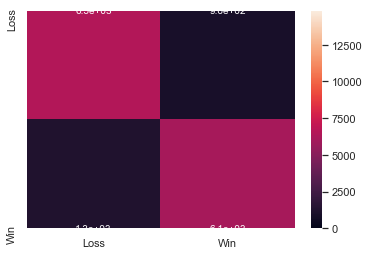

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7492910195813639

ROC/AUC Score: 0.7490611957994169
              precision    recall  f1-score   support

        Loss       0.74      0.78      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5847  1606
Win   2107  5250


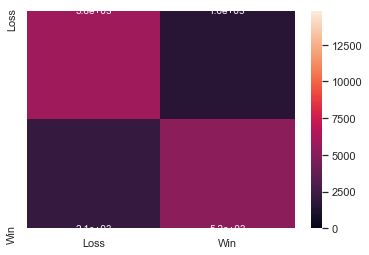

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
85,KNeighborsClassifier,diff-ohe-matchup10_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.832343,0.832250,"{""0"": {""0"": 6310, ""1"": 1340}, ""1"": {""0"": 1143,...","{""Loss"": {""precision"": 0.8248366013071895, ""re...",../models/kneighborsclassifier-1998-2018-diff-...,0.0,0.0,0.0
86,DecisionTreeClassifier,diff-ohe-matchup10_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.923498,0.923469,"{""0"": {""0"": 6915, ""1"": 595}, ""1"": {""0"": 538, ""...","{""Loss"": {""precision"": 0.9207723035952063, ""re...",../models/decisiontreeclassifier-1998-2018-dif...,0.0,0.0,0.0
87,RandomForestClassifier,diff-ohe-matchup10_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.796894,0.796675,"{""0"": {""0"": 6189, ""1"": 1744}, ""1"": {""0"": 1264,...","{""Loss"": {""precision"": 0.7801588302029497, ""re...",../models/randomforestclassifier-1998-2018-dif...,0.0,0.0,0.0
88,GradientBoostingClassifier,diff-ohe-matchup10_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.849764,0.849628,"{""0"": {""0"": 6488, ""1"": 1260}, ""1"": {""0"": 965, ...","{""Loss"": {""precision"": 0.8373773877129582, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,11.0,11.0
89,AdaBoostClassifier,diff-ohe-matchup10_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.749291,0.749061,"{""0"": {""0"": 5847, ""1"": 2107}, ""1"": {""0"": 1606,...","{""Loss"": {""precision"": 0.735101835554438, ""rec...",../models/adaboostclassifier-1998-2018-diff-oh...,0.0,1.0,1.0


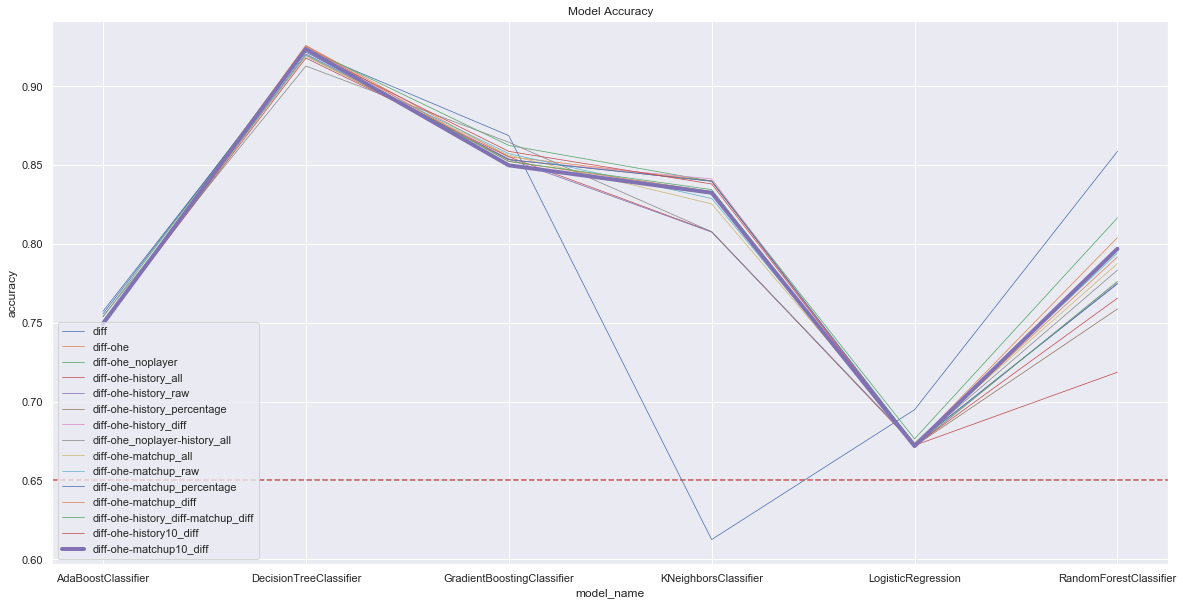

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

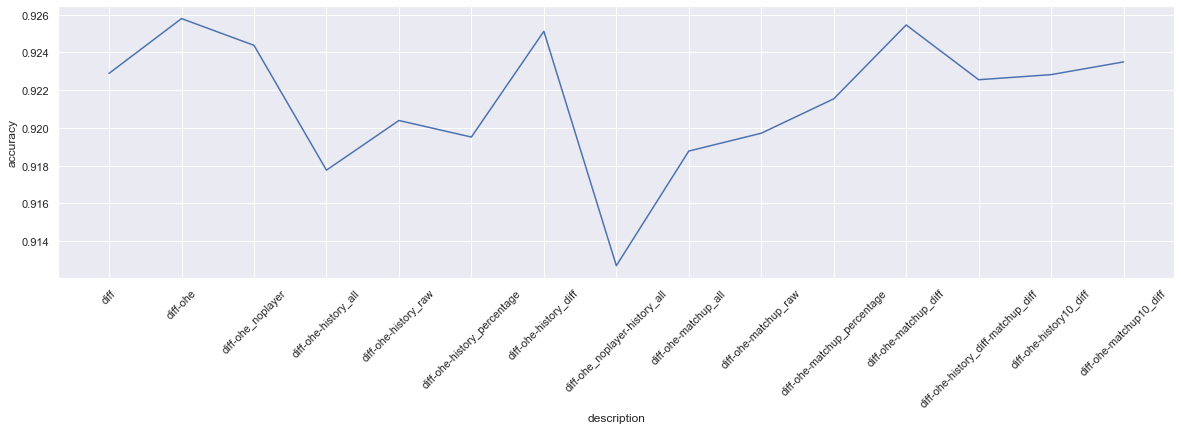

In [31]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


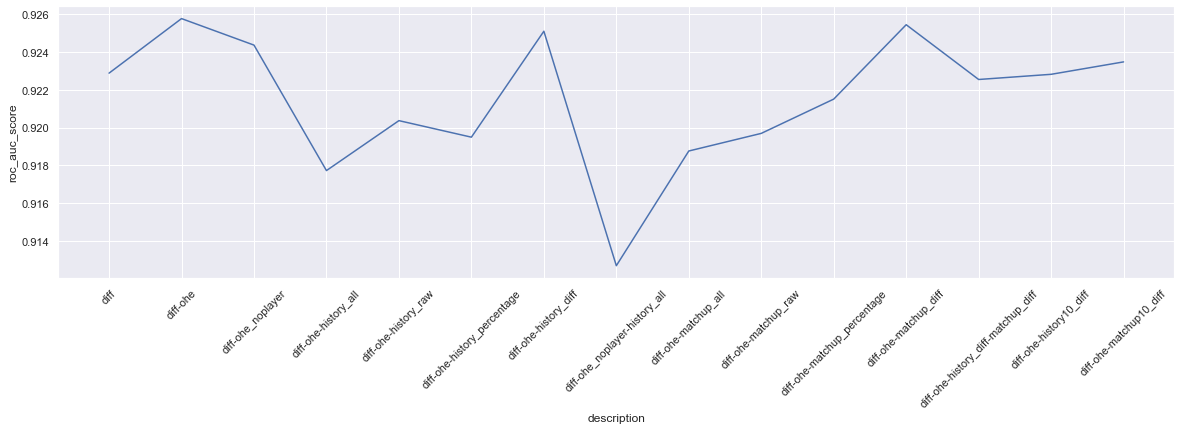

In [36]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="roc_auc_score", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier ROC/AUC Score")
_ = plt.xticks(rotation=45)


In [32]:
import shap

shap.initjs()

mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)



(2, 14810, 5254)


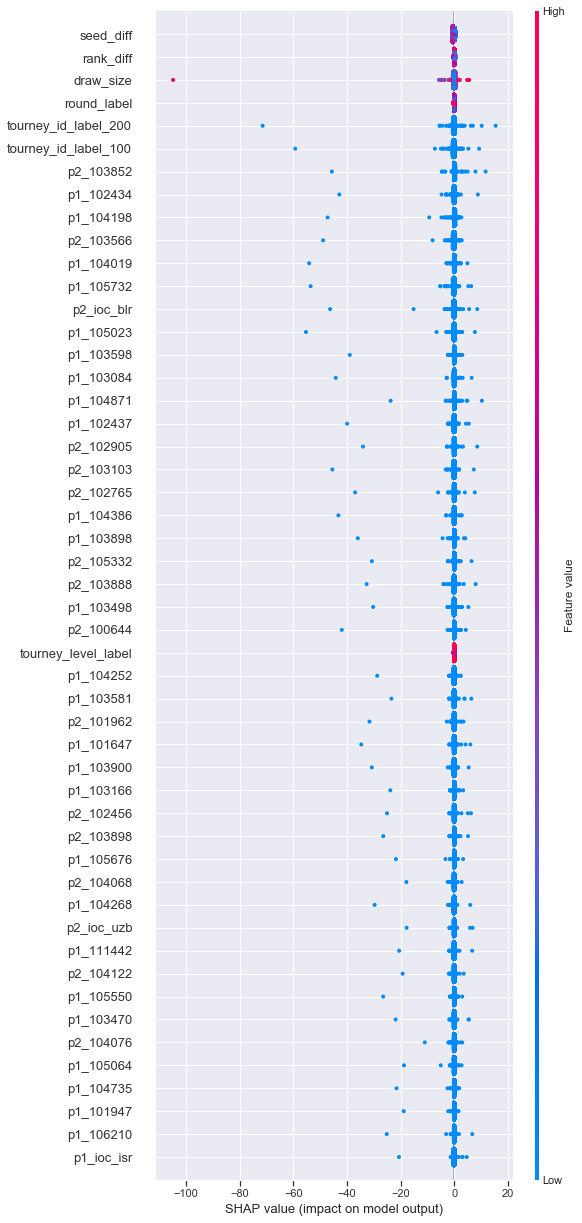

In [33]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=50)

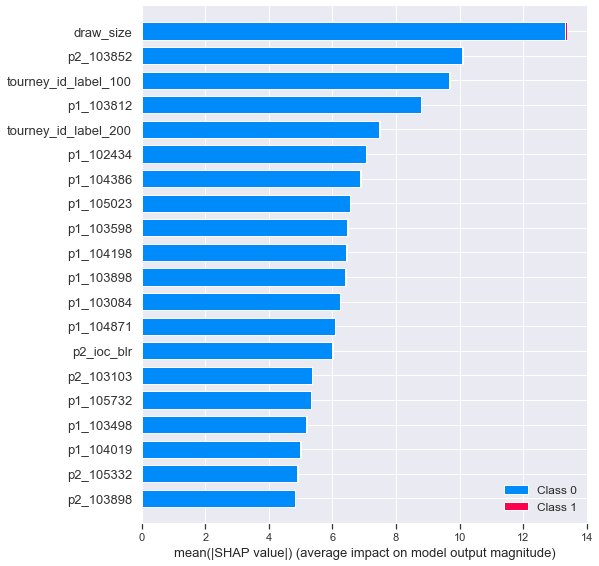

In [34]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, title="Feature Importance")